# 2 - MNIST CNN Network

Adapted from this tutorial -> https://victorzhou.com/blog/keras-cnn-tutorial/#the-full-code

`github.com/samph4`

~

### Preface

This example will use the same MNIST dataset as we used in the last example. However, this time we are going to train a different class of neural network. This time, we'll be using a Convolutional Neural Network (CNN). CNN's are extremely popular recently as they have revolutionised the field of computer vision as they are well equipped to deal with and process data in image format. There is an article by Victor Zhou (https://victorzhou.com/blog/intro-to-cnns-part-1/) that does an excellent job introducing what a CNN is, but I'll try and summarise his key points here.

A classic use of CNNs is to perform image classification e.g. looking at an image of a pet and determining whether it is a cat or a dog. CNN's can achieve extraordinary results in this regard and some of the most successful and popular CNN networks achieve accuracies of over 88 % on famous image databases such as ImageNet that contains over 14 million images  belonging to ~22,000 categories (where one category might be a cat). You can quickly begin to appreciate the capabilities of these networks and the tasks they might be able to perform. It is a fantastic time to get into machine learning since large improvements in the field have been made in the last 10 years: the image below shows the progression of the 'state of the art' trained networks on the ImageNet database (taken from https://paperswithcode.com/sota/image-classification-on-imagenet).

![Image](./Figures/cnn_exp.png)

Determining whether or not an image is of a cat or a dog seems straight forward, couldn't we just use a standard neural network (MLP)? The answer is yes, but it might be an extremely inefficient solution. The reason being that images can be very big (depending on pixel size). 

> "Images used for Computer Vision problems nowadays are often 224x224 or larger. Imagine building a neural network to process 224x224 color images: including the 3 color channels (RGB) in the image, that comes out to 224 x 224 x 3 = 150,528 input features! A typical hidden layer in such a network might have 1024 nodes, so we’d have to train 150,528 x 1024 = 150+ million weights for the first layer alone. Our network would be huge and nearly impossible to train." - https://victorzhou.com/blog/intro-to-cnns-part-1/.

This is exactly what we did in the previous example, where we took the 28x28 input image (MNIST digit) and flattened it to form a feature vector of 784 elements. This quickly gets out of hand with larger image sizes and as a result training times and convergence can suffer. Nor is it the most logical approach. Intuitively, when we consider an image we interpret the image based on a collection of pixels. Pixels are most useful in the context of their neighbours and as humans we gather much more information from a collection of pixels rather than isolated, indivudal colours. Objects in images are made up of small, *localised* features, like the circular iris of an eye or the square corner of a piece of paper. Doesn't it seem wasteful for every node in the first hidden layer to look at every single pixel? Could it therefore be helpful to try and create something that adopts similar practicices? Also, positions can change. And this is particularly important. If we train a network that is capable of identifying a cat, we would want the model to be able to detect that cat regardless of where it appears in the image.

> "Imagine training a network that works well on a certain dog image, but then feeding it a slightly shifted version of the same image. The dog would not activate the same neurons, so the network would react completely differently!". - https://victorzhou.com/blog/intro-to-cnns-part-1/.

We did not run into this problem in the previous example since the MNIST dataset had been structured for us. The dataset contains small images (low # of pixels = low # of features) that, more imporantly, had been centered so we did not encounter the issue of shifting or funky orientations.

~

## What are CNNs?

![Image](./Figures/cnn.jpeg)

~ bunch of text about how they work - refer to video honestly.

In [1]:
!pip install mnist

#### Necessary Imports

In [2]:
import numpy as np 
from tensorflow import keras 
#from keras.datasets import mnist
import mnist # import mnist directly to access more info
import matplotlib.pyplot as plt

In [3]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

print(train_images.shape) # (60000, 28, 28)
print(train_labels.shape) # (60000,)

(60000, 28, 28)
(60000,)


Before we begin, we’ll normalize the image pixel values from [0, 255] to [-0.5, 0.5] to make our network easier to train (using smaller, centered values usually leads to better results). We’ll also reshape each image from (28, 28) to (28, 28, 1) because Keras requires the third dimension.

In [4]:
# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

print(train_images.shape) # (60000, 28, 28, 1)
print(test_images.shape)  # (10000, 28, 28, 1)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

num_filters = 8
filter_size = 3
pool_size = 2

model = Sequential()

model.add(Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [8]:
from tensorflow.keras.utils import to_categorical

model.fit(train_images,to_categorical(train_labels), epochs=3,validation_data=(test_images, to_categorical(test_labels)))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3


   32/60000 [..............................] - ETA: 55:45 - loss: 2.2376 - accuracy: 0.3125

  800/60000 [..............................] - ETA: 2:16 - loss: 2.0486 - accuracy: 0.3775 

 1568/60000 [..............................] - ETA: 1:10 - loss: 1.7731 - accuracy: 0.5332

 2176/60000 [>.............................] - ETA: 51s - loss: 1.5617 - accuracy: 0.6052 

 2816/60000 [>.............................] - ETA: 40s - loss: 1.3768 - accuracy: 0.6566

 3744/60000 [>.............................] - ETA: 30s - loss: 1.1884 - accuracy: 0.7011

 4768/60000 [=>............................] - ETA: 24s - loss: 1.0394 - accuracy: 0.7374

 5472/60000 [=>............................] - ETA: 21s - loss: 0.9676 - accuracy: 0.7542

 6208/60000 [==>...........................] - ETA: 19s - loss: 0.9075 - accuracy: 0.7674

 6944/60000 [==>...........................] - ETA: 17s - loss: 0.8590 - accuracy: 0.7794

 7712/60000 [==>...........................] - ETA: 15s - loss: 0.8158 - accuracy: 0.7872

 8480/60000 [===>..........................] - ETA: 14s - loss: 0.7773 - accuracy: 0.7972

 9408/60000 [===>..........................] - ETA: 12s - loss: 0.7394 - accuracy: 0.8060

10464/60000 [====>.........................] - ETA: 11s - loss: 0.7009 - accuracy: 0.8148

11552/60000 [====>.........................] - ETA: 10s - loss: 0.6674 - accuracy: 0.8222

12288/60000 [=====>........................] - ETA: 9s - loss: 0.6485 - accuracy: 0.8263 



12992/60000 [=====>........................] - ETA: 9s - loss: 0.6309 - accuracy: 0.8307

13856/60000 [=====>........................] - ETA: 8s - loss: 0.6139 - accuracy: 0.8347

14688/60000 [======>.......................] - ETA: 8s - loss: 0.5993 - accuracy: 0.8377

15520/60000 [======>.......................] - ETA: 7s - loss: 0.5850 - accuracy: 0.8409

16288/60000 [=======>......................] - ETA: 7s - loss: 0.5748 - accuracy: 0.8436

17056/60000 [=======>......................] - ETA: 7s - loss: 0.5648 - accuracy: 0.8453

17920/60000 [=======>......................] - ETA: 6s - loss: 0.5511 - accuracy: 0.8482



18944/60000 [========>.....................] - ETA: 6s - loss: 0.5395 - accuracy: 0.8517

19616/60000 [========>.....................] - ETA: 6s - loss: 0.5309 - accuracy: 0.8535

20384/60000 [=========>....................] - ETA: 5s - loss: 0.5213 - accuracy: 0.8562

21216/60000 [=========>....................] - ETA: 5s - loss: 0.5135 - accuracy: 0.8582

22048/60000 [==========>...................] - ETA: 5s - loss: 0.5044 - accuracy: 0.8605

22848/60000 [==========>...................] - ETA: 5s - loss: 0.4964 - accuracy: 0.8625

23680/60000 [==========>...................] - ETA: 5s - loss: 0.4890 - accuracy: 0.8645

24736/60000 [===========>..................] - ETA: 4s - loss: 0.4804 - accuracy: 0.8666

25824/60000 [===========>..................] - ETA: 4s - loss: 0.4712 - accuracy: 0.8688

26656/60000 [============>.................] - ETA: 4s - loss: 0.4645 - accuracy: 0.8703

27424/60000 [============>.................] - ETA: 4s - loss: 0.4585 - accuracy: 0.8716

28192/60000 [=============>................] - ETA: 3s - loss: 0.4562 - accuracy: 0.8722

28928/60000 [=============>................] - ETA: 3s - loss: 0.4507 - accuracy: 0.8733

29664/60000 [=============>................] - ETA: 3s - loss: 0.4461 - accuracy: 0.8745



30400/60000 [==============>...............] - ETA: 3s - loss: 0.4417 - accuracy: 0.8757

31328/60000 [==============>...............] - ETA: 3s - loss: 0.4357 - accuracy: 0.8775

32320/60000 [===============>..............] - ETA: 3s - loss: 0.4299 - accuracy: 0.8787

33376/60000 [===============>..............] - ETA: 3s - loss: 0.4239 - accuracy: 0.8804

34400/60000 [================>.............] - ETA: 2s - loss: 0.4180 - accuracy: 0.8820

35424/60000 [================>.............] - ETA: 2s - loss: 0.4138 - accuracy: 0.8833

36320/60000 [=================>............] - ETA: 2s - loss: 0.4084 - accuracy: 0.8849



37184/60000 [=================>............] - ETA: 2s - loss: 0.4056 - accuracy: 0.8856

38048/60000 [==================>...........] - ETA: 2s - loss: 0.4011 - accuracy: 0.8870

38912/60000 [==================>...........] - ETA: 2s - loss: 0.3969 - accuracy: 0.8880

39808/60000 [==================>...........] - ETA: 2s - loss: 0.3932 - accuracy: 0.8888



40736/60000 [===================>..........] - ETA: 2s - loss: 0.3909 - accuracy: 0.8895

41632/60000 [===================>..........] - ETA: 1s - loss: 0.3882 - accuracy: 0.8903

42496/60000 [====================>.........] - ETA: 1s - loss: 0.3841 - accuracy: 0.8913

43392/60000 [====================>.........] - ETA: 1s - loss: 0.3809 - accuracy: 0.8922



44384/60000 [=====================>........] - ETA: 1s - loss: 0.3767 - accuracy: 0.8935



45504/60000 [=====================>........] - ETA: 1s - loss: 0.3728 - accuracy: 0.8946

46592/60000 [======================>.......] - ETA: 1s - loss: 0.3693 - accuracy: 0.8956

47680/60000 [======================>.......] - ETA: 1s - loss: 0.3660 - accuracy: 0.8966

48768/60000 [=======================>......] - ETA: 1s - loss: 0.3633 - accuracy: 0.8974

49888/60000 [=======================>......] - ETA: 0s - loss: 0.3599 - accuracy: 0.8984

50976/60000 [========================>.....] - ETA: 0s - loss: 0.3565 - accuracy: 0.8994

52096/60000 [=========================>....] - ETA: 0s - loss: 0.3537 - accuracy: 0.9003



53216/60000 [=========================>....] - ETA: 0s - loss: 0.3501 - accuracy: 0.9013

54272/60000 [==========================>...] - ETA: 0s - loss: 0.3472 - accuracy: 0.9021

55360/60000 [==========================>...] - ETA: 0s - loss: 0.3445 - accuracy: 0.9028

56352/60000 [===========================>..] - ETA: 0s - loss: 0.3419 - accuracy: 0.9034



57376/60000 [===========================>..] - ETA: 0s - loss: 0.3393 - accuracy: 0.9041

58400/60000 [============================>.] - ETA: 0s - loss: 0.3368 - accuracy: 0.9049

59520/60000 [============================>.] - ETA: 0s - loss: 0.3343 - accuracy: 0.9056

60000/60000 [==============================] - 6s 98us/sample - loss: 0.3333 - accuracy: 0.9058 - val_loss: 0.1874 - val_accuracy: 0.9465


Epoch 2/3
   32/60000 [..............................] - ETA: 3s - loss: 0.1977 - accuracy: 0.9688

 1088/60000 [..............................] - ETA: 2s - loss: 0.1992 - accuracy: 0.9403

 2176/60000 [>.............................] - ETA: 2s - loss: 0.1876 - accuracy: 0.9453

 3008/60000 [>.............................] - ETA: 2s - loss: 0.1879 - accuracy: 0.9471

 3712/60000 [>.............................] - ETA: 3s - loss: 0.1860 - accuracy: 0.9469

 4352/60000 [=>............................] - ETA: 3s - loss: 0.1895 - accuracy: 0.9467

 4992/60000 [=>............................] - ETA: 3s - loss: 0.1875 - accuracy: 0.9465

 5664/60000 [=>............................] - ETA: 3s - loss: 0.1910 - accuracy: 0.9458

 6432/60000 [==>...........................] - ETA: 3s - loss: 0.1879 - accuracy: 0.9462

 7168/60000 [==>...........................] - ETA: 3s - loss: 0.1914 - accuracy: 0.9448

 8224/60000 [===>..........................] - ETA: 3s - loss: 0.1935 - accuracy: 0.9447

 9312/60000 [===>..........................] - ETA: 3s - loss: 0.1960 - accuracy: 0.9438

10016/60000 [====>.........................] - ETA: 3s - loss: 0.1930 - accuracy: 0.9445

10720/60000 [====>.........................] - ETA: 3s - loss: 0.1945 - accuracy: 0.9441

11456/60000 [====>.........................] - ETA: 3s - loss: 0.1933 - accuracy: 0.9444

12192/60000 [=====>........................] - ETA: 3s - loss: 0.1934 - accuracy: 0.9439

12928/60000 [=====>........................] - ETA: 3s - loss: 0.1924 - accuracy: 0.9439

13760/60000 [=====>........................] - ETA: 2s - loss: 0.1930 - accuracy: 0.9435

14816/60000 [======>.......................] - ETA: 2s - loss: 0.1926 - accuracy: 0.9435

15936/60000 [======>.......................] - ETA: 2s - loss: 0.1907 - accuracy: 0.9439

17056/60000 [=======>......................] - ETA: 2s - loss: 0.1881 - accuracy: 0.9450

18112/60000 [========>.....................] - ETA: 2s - loss: 0.1862 - accuracy: 0.9458



19200/60000 [========>.....................] - ETA: 2s - loss: 0.1836 - accuracy: 0.9466

20224/60000 [=========>....................] - ETA: 2s - loss: 0.1845 - accuracy: 0.9462

21344/60000 [=========>....................] - ETA: 2s - loss: 0.1830 - accuracy: 0.9471

22464/60000 [==========>...................] - ETA: 2s - loss: 0.1818 - accuracy: 0.9476

23584/60000 [==========>...................] - ETA: 2s - loss: 0.1803 - accuracy: 0.9483



24704/60000 [===========>..................] - ETA: 1s - loss: 0.1787 - accuracy: 0.9487

25824/60000 [===========>..................] - ETA: 1s - loss: 0.1775 - accuracy: 0.9492

26944/60000 [============>.................] - ETA: 1s - loss: 0.1767 - accuracy: 0.9495

28064/60000 [=============>................] - ETA: 1s - loss: 0.1765 - accuracy: 0.9492

29184/60000 [=============>................] - ETA: 1s - loss: 0.1752 - accuracy: 0.9498

30208/60000 [==============>...............] - ETA: 1s - loss: 0.1750 - accuracy: 0.9497

31200/60000 [==============>...............] - ETA: 1s - loss: 0.1731 - accuracy: 0.9503

32224/60000 [===============>..............] - ETA: 1s - loss: 0.1723 - accuracy: 0.9502

33152/60000 [===============>..............] - ETA: 1s - loss: 0.1722 - accuracy: 0.9504

34144/60000 [================>.............] - ETA: 1s - loss: 0.1713 - accuracy: 0.9507

34912/60000 [================>.............] - ETA: 1s - loss: 0.1709 - accuracy: 0.9508



35808/60000 [================>.............] - ETA: 1s - loss: 0.1718 - accuracy: 0.9506

36800/60000 [=================>............] - ETA: 1s - loss: 0.1715 - accuracy: 0.9508

37760/60000 [=================>............] - ETA: 1s - loss: 0.1708 - accuracy: 0.9511

38784/60000 [==================>...........] - ETA: 1s - loss: 0.1707 - accuracy: 0.9510

39776/60000 [==================>...........] - ETA: 1s - loss: 0.1704 - accuracy: 0.9510

40832/60000 [===================>..........] - ETA: 1s - loss: 0.1695 - accuracy: 0.9512

41888/60000 [===================>..........] - ETA: 0s - loss: 0.1689 - accuracy: 0.9514

42912/60000 [====================>.........] - ETA: 0s - loss: 0.1680 - accuracy: 0.9516



44032/60000 [=====================>........] - ETA: 0s - loss: 0.1671 - accuracy: 0.9519

45120/60000 [=====================>........] - ETA: 0s - loss: 0.1665 - accuracy: 0.9521

46176/60000 [======================>.......] - ETA: 0s - loss: 0.1663 - accuracy: 0.9522

47296/60000 [======================>.......] - ETA: 0s - loss: 0.1662 - accuracy: 0.9521



48416/60000 [=======================>......] - ETA: 0s - loss: 0.1667 - accuracy: 0.9520

49472/60000 [=======================>......] - ETA: 0s - loss: 0.1664 - accuracy: 0.9520

50592/60000 [========================>.....] - ETA: 0s - loss: 0.1659 - accuracy: 0.9521

51712/60000 [========================>.....] - ETA: 0s - loss: 0.1655 - accuracy: 0.9524



52832/60000 [=========================>....] - ETA: 0s - loss: 0.1652 - accuracy: 0.9524

53952/60000 [=========================>....] - ETA: 0s - loss: 0.1645 - accuracy: 0.9526

55040/60000 [==========================>...] - ETA: 0s - loss: 0.1644 - accuracy: 0.9528

56160/60000 [===========================>..] - ETA: 0s - loss: 0.1637 - accuracy: 0.9530



57248/60000 [===========================>..] - ETA: 0s - loss: 0.1631 - accuracy: 0.9532

58272/60000 [============================>.] - ETA: 0s - loss: 0.1629 - accuracy: 0.9534

59296/60000 [============================>.] - ETA: 0s - loss: 0.1622 - accuracy: 0.9537

60000/60000 [==============================] - 4s 60us/sample - loss: 0.1616 - accuracy: 0.9538 - val_loss: 0.1311 - val_accuracy: 0.9591


Epoch 3/3
   32/60000 [..............................] - ETA: 3s - loss: 0.0273 - accuracy: 1.0000

  992/60000 [..............................] - ETA: 3s - loss: 0.1478 - accuracy: 0.9617

 1952/60000 [..............................] - ETA: 3s - loss: 0.1481 - accuracy: 0.9652

 2944/60000 [>.............................] - ETA: 3s - loss: 0.1417 - accuracy: 0.9643

 3936/60000 [>.............................] - ETA: 2s - loss: 0.1363 - accuracy: 0.9644

 4960/60000 [=>............................] - ETA: 2s - loss: 0.1410 - accuracy: 0.9613



 5984/60000 [=>............................] - ETA: 2s - loss: 0.1410 - accuracy: 0.9612

 6976/60000 [==>...........................] - ETA: 2s - loss: 0.1414 - accuracy: 0.9607

 7968/60000 [==>...........................] - ETA: 2s - loss: 0.1411 - accuracy: 0.9612

 9024/60000 [===>..........................] - ETA: 2s - loss: 0.1365 - accuracy: 0.9625



10112/60000 [====>.........................] - ETA: 2s - loss: 0.1351 - accuracy: 0.9631

11168/60000 [====>.........................] - ETA: 2s - loss: 0.1337 - accuracy: 0.9625

12192/60000 [=====>........................] - ETA: 2s - loss: 0.1332 - accuracy: 0.9624

12960/60000 [=====>........................] - ETA: 2s - loss: 0.1318 - accuracy: 0.9629

13568/60000 [=====>........................] - ETA: 2s - loss: 0.1318 - accuracy: 0.9630

14208/60000 [======>.......................] - ETA: 2s - loss: 0.1310 - accuracy: 0.9630

14848/60000 [======>.......................] - ETA: 2s - loss: 0.1310 - accuracy: 0.9628



15584/60000 [======>.......................] - ETA: 2s - loss: 0.1311 - accuracy: 0.9630

16288/60000 [=======>......................] - ETA: 2s - loss: 0.1297 - accuracy: 0.9632

17120/60000 [=======>......................] - ETA: 2s - loss: 0.1301 - accuracy: 0.9634

17856/60000 [=======>......................] - ETA: 2s - loss: 0.1300 - accuracy: 0.9633

18560/60000 [========>.....................] - ETA: 2s - loss: 0.1303 - accuracy: 0.9633

19168/60000 [========>.....................] - ETA: 2s - loss: 0.1316 - accuracy: 0.9629

19776/60000 [========>.....................] - ETA: 2s - loss: 0.1313 - accuracy: 0.9628

20480/60000 [=========>....................] - ETA: 2s - loss: 0.1302 - accuracy: 0.9629

21184/60000 [=========>....................] - ETA: 2s - loss: 0.1291 - accuracy: 0.9631

21920/60000 [=========>....................] - ETA: 2s - loss: 0.1294 - accuracy: 0.9631

22912/60000 [==========>...................] - ETA: 2s - loss: 0.1281 - accuracy: 0.9636

23648/60000 [==========>...................] - ETA: 2s - loss: 0.1286 - accuracy: 0.9637

24768/60000 [===========>..................] - ETA: 2s - loss: 0.1282 - accuracy: 0.9639

25920/60000 [===========>..................] - ETA: 2s - loss: 0.1289 - accuracy: 0.9637

26976/60000 [============>.................] - ETA: 1s - loss: 0.1292 - accuracy: 0.9635

27968/60000 [============>.................] - ETA: 1s - loss: 0.1298 - accuracy: 0.9634

29088/60000 [=============>................] - ETA: 1s - loss: 0.1292 - accuracy: 0.9636

30208/60000 [==============>...............] - ETA: 1s - loss: 0.1292 - accuracy: 0.9636

30976/60000 [==============>...............] - ETA: 1s - loss: 0.1293 - accuracy: 0.9636



31712/60000 [==============>...............] - ETA: 1s - loss: 0.1288 - accuracy: 0.9638

32384/60000 [===============>..............] - ETA: 1s - loss: 0.1286 - accuracy: 0.9639

33120/60000 [===============>..............] - ETA: 1s - loss: 0.1283 - accuracy: 0.9640

33792/60000 [===============>..............] - ETA: 1s - loss: 0.1286 - accuracy: 0.9638

34464/60000 [================>.............] - ETA: 1s - loss: 0.1284 - accuracy: 0.9639

35104/60000 [================>.............] - ETA: 1s - loss: 0.1277 - accuracy: 0.9640

35776/60000 [================>.............] - ETA: 1s - loss: 0.1274 - accuracy: 0.9641



36448/60000 [=================>............] - ETA: 1s - loss: 0.1277 - accuracy: 0.9640

37216/60000 [=================>............] - ETA: 1s - loss: 0.1278 - accuracy: 0.9640

37920/60000 [=================>............] - ETA: 1s - loss: 0.1276 - accuracy: 0.9641

38592/60000 [==================>...........] - ETA: 1s - loss: 0.1273 - accuracy: 0.9641

39232/60000 [==================>...........] - ETA: 1s - loss: 0.1267 - accuracy: 0.9642

39936/60000 [==================>...........] - ETA: 1s - loss: 0.1267 - accuracy: 0.9641

40640/60000 [===================>..........] - ETA: 1s - loss: 0.1260 - accuracy: 0.9643



41312/60000 [===================>..........] - ETA: 1s - loss: 0.1258 - accuracy: 0.9645

42048/60000 [====================>.........] - ETA: 1s - loss: 0.1262 - accuracy: 0.9643

43104/60000 [====================>.........] - ETA: 1s - loss: 0.1260 - accuracy: 0.9645

44064/60000 [=====================>........] - ETA: 0s - loss: 0.1263 - accuracy: 0.9644



44800/60000 [=====================>........] - ETA: 0s - loss: 0.1263 - accuracy: 0.9643

45920/60000 [=====================>........] - ETA: 0s - loss: 0.1262 - accuracy: 0.9644

47040/60000 [======================>.......] - ETA: 0s - loss: 0.1258 - accuracy: 0.9646

48192/60000 [=======================>......] - ETA: 0s - loss: 0.1253 - accuracy: 0.9647



49344/60000 [=======================>......] - ETA: 0s - loss: 0.1247 - accuracy: 0.9648

50464/60000 [========================>.....] - ETA: 0s - loss: 0.1246 - accuracy: 0.9647

51616/60000 [========================>.....] - ETA: 0s - loss: 0.1244 - accuracy: 0.9647

52704/60000 [=========================>....] - ETA: 0s - loss: 0.1238 - accuracy: 0.9649

53824/60000 [=========================>....] - ETA: 0s - loss: 0.1234 - accuracy: 0.9650

54944/60000 [==========================>...] - ETA: 0s - loss: 0.1226 - accuracy: 0.9652

56064/60000 [===========================>..] - ETA: 0s - loss: 0.1225 - accuracy: 0.9652



57184/60000 [===========================>..] - ETA: 0s - loss: 0.1223 - accuracy: 0.9652

58144/60000 [============================>.] - ETA: 0s - loss: 0.1230 - accuracy: 0.9651

58848/60000 [============================>.] - ETA: 0s - loss: 0.1232 - accuracy: 0.9651

59392/60000 [============================>.] - ETA: 0s - loss: 0.1231 - accuracy: 0.9651

59968/60000 [============================>.] - ETA: 0s - loss: 0.1231 - accuracy: 0.9651

60000/60000 [==============================] - 4s 72us/sample - loss: 0.1231 - accuracy: 0.9651 - val_loss: 0.1021 - val_accuracy: 0.9677


## Test

In [9]:
# Test the model after training
test_results = model.evaluate(test_images, to_categorical(test_labels), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

   32/10000 [..............................] - ETA: 0s - loss: 0.1184 - accuracy: 0.9375

 1152/10000 [==>...........................] - ETA: 0s - loss: 0.1148 - accuracy: 0.9618

 2336/10000 [======>.......................] - ETA: 0s - loss: 0.1373 - accuracy: 0.9529



 3456/10000 [=========>....................] - ETA: 0s - loss: 0.1271 - accuracy: 0.9578

 4352/10000 [============>.................] - ETA: 0s - loss: 0.1352 - accuracy: 0.9554

 5056/10000 [==============>...............] - ETA: 0s - loss: 0.1329 - accuracy: 0.9555

 5760/10000 [================>.............] - ETA: 0s - loss: 0.1248 - accuracy: 0.9582

 6496/10000 [==================>...........] - ETA: 0s - loss: 0.1222 - accuracy: 0.9600

 7392/10000 [=====================>........] - ETA: 0s - loss: 0.1158 - accuracy: 0.9623



 8544/10000 [========================>.....] - ETA: 0s - loss: 0.1083 - accuracy: 0.9649

 9664/10000 [===========================>..] - ETA: 0s - loss: 0.1009 - accuracy: 0.9677

10000/10000 [==============================] - 1s 53us/sample - loss: 0.1021 - accuracy: 0.9677


Test results - Loss: 0.10211860797293484 - Accuracy: 96.77000045776367%


In [10]:
predictions = model.predict(test_images[:5])

In [11]:
predictions

array([[2.88385309e-06, 1.95969079e-07, 5.23912831e-06, 3.33484873e-04,
        8.65341633e-07, 5.28750263e-07, 1.59221233e-10, 9.99633551e-01,
        5.41199157e-08, 2.32077200e-05],
       [5.67820272e-04, 3.58440983e-03, 9.77266252e-01, 4.89940285e-04,
        7.91265080e-08, 2.87690928e-04, 1.50300525e-02, 7.86491081e-11,
        2.77368049e-03, 7.05390448e-08],
       [1.15947050e-05, 9.98153150e-01, 2.37760149e-04, 7.57042017e-06,
        2.29142432e-04, 9.93438334e-06, 5.30522739e-05, 1.28020265e-03,
        1.52252778e-05, 2.39826318e-06],
       [9.87601280e-01, 6.72099850e-06, 1.00592654e-02, 7.11208440e-06,
        8.23018581e-06, 1.25718454e-03, 7.10454595e-04, 1.99864255e-04,
        3.48503781e-05, 1.15053808e-04],
       [1.51429573e-04, 6.58472982e-06, 1.37497162e-04, 9.21420269e-06,
        9.98410821e-01, 2.23744536e-07, 1.76881163e-04, 1.34552291e-04,
        7.82733423e-06, 9.64870793e-04]], dtype=float32)

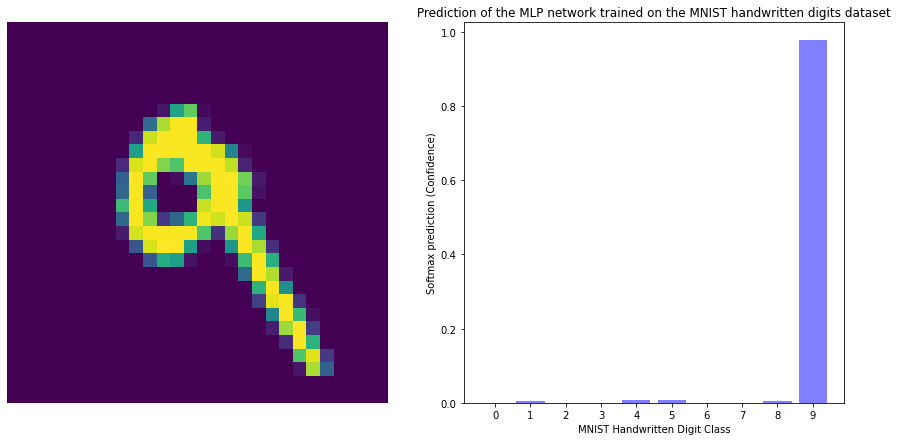

In [12]:
# create subplot to show input and its prediction
plt.figure(figsize=(15,7))

index = 7
test_input = test_images[index,:,:]


# MNIST test input (1st subplot)
plt.subplot(1,2,1)
plt.imshow(test_input.reshape(28,28))
plt.axis('off')

# bar chart (2nd subplot)
plt.subplot(1,2,2)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# prepare input to cnn
cnn_test_input = test_images[index]
cnn_test_input = cnn_test_input.reshape(1,28,28,1)
prediction = model.predict(cnn_test_input)
prediction = prediction[0,:].tolist() # convert prediction array into list to plot on chart

plt.bar(class_names, prediction, align='center', alpha=0.5, color='blue')
plt.xticks(class_names, class_names)
plt.xlabel('MNIST Handwritten Digit Class')
plt.ylabel('Softmax prediction (Confidence)')
plt.title('Prediction of the MLP network trained on the MNIST handwritten digits dataset')

plt.show()